In [1]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from matplotlib import cm

## Auxiliary functions

In [2]:
# This function calculates the prior, likelihood and posterior distributions from the selected parameters
#
# The parameters parameter is a dictionary with the following fields:
#   - a_w: alpha parameter for omega's beta distribution
#   - b_w: beta parameter for omega's beta distribution
#   - k: k parameter for theta's beta distribution
#   - n: number of observed coin flips (array with two elements, one for each coin)
#   - z: number of observed heads (array with two elements, one for each coin)
def calculate_pdfs(paremeters, granularity = 100):
    theta = np.linspace(0, 1, granularity)
    omega = np.linspace(0, 1, granularity)
    width_t = theta[1]
    width_w = omega[1]
    THETA, OMEGA = np.meshgrid(theta, omega)
    
    prior = []
    likelihood = []
    posterior = []
    for i in range(2):
        prior.append(np.multiply(beta.pdf(THETA, 
                                          OMEGA * (parameters['k'] - 2) + 1, 
                                          (1 - OMEGA) * (parameters['k'] - 2) + 1), 
                                 beta.pdf(OMEGA, parameters['a_w'], parameters['b_w'])))
        prior[-1] = prior[-1] / (np.sum(np.sum(prior[-1])) * width_t * width_w)
        likelihood.append(np.multiply(np.power(THETA, parameters['z'][i]), 
                                      np.power(1 - THETA, parameters['n'][i] - parameters['z'][i])))
        posterior.append(np.multiply(prior[-1], likelihood[-1])) 
        posterior[-1] = posterior[-1] / (np.sum(np.sum(posterior[-1])) * width_t * width_w)
    
    return theta, omega, prior, likelihood, posterior

In [3]:
# Plots the top or bottom section of the figure, i.e. the prior and the posterior sections
# The pdf parameter is either the priors or the posteriors calculated by the function above
# If parameters is assigned the parameters dictionary, the function will be assuming that it is plotting
# the top section (prior) and will adapt the label accordingly
def plot_prior_posterior(pdf, theta, omega, parameters = None):
    THETA, OMEGA = np.meshgrid(theta, omega)
    marginal_theta = []
    for i in range(2):
        marginal_theta.append(np.sum(pdf[i], axis = 0) / pdf[i].shape[1])
    marginal_omega = np.sum(pdf[0], axis = 1) / pdf[0].shape[0]
    
    fig = plt.figure(constrained_layout = False)
    gs = fig.add_gridspec(2, 3)
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.contourf(THETA, OMEGA, pdf[0], cmap = cm.coolwarm)
    ax1.set_xlabel(r'$\theta_1$')
    ax1.set_ylabel(r'$\omega$')
    
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.contourf(THETA, OMEGA, pdf[1], cmap = cm.coolwarm)
    ax2.set_xlabel(r'$\theta_2$')
    ax2.set_ylabel(r'$\omega$')

    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(marginal_omega, omega)
    ax3.set_xlabel(r'$p(\omega)$')
    ax3.set_ylabel(r'$\omega$')
    
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.plot(theta, marginal_theta[0])
    ax4.set_xlabel(r'$\theta_1$')
    ax4.set_ylabel(r'$p(\theta_1)$')
    
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.plot(theta, marginal_theta[1])
    ax5.set_xlabel(r'$\theta_2$')
    ax5.set_ylabel(r'$p(\theta_2)$')

    ax6 = fig.add_subplot(gs[1, 2])
    ax6.axis('off')
    if parameters is not None:
        parameters_str = '$A_{\omega}$ = ' + \
                         str(parameters['a_w']) + \
                         ', $B_{\omega}$ = ' + \
                         str(parameters['b_w']) + \
                         '\nK = ' + \
                         str(parameters['k'])
        ax6.text(0, 0.65, 'Prior', transform = ax6.transAxes, fontsize = 18, horizontalalignment = 'left')
        ax6.text(0, 0.4, parameters_str, transform = ax6.transAxes, fontsize = 12, horizontalalignment = 'left')
    else:
        ax6.text(0, 0.65, 'Posterior', transform = ax6.transAxes, fontsize = 18, horizontalalignment = 'left')

    fig.set_figwidth(8)
    fig.set_figheight(5)
    plt.tight_layout()
    
    return [ax1, ax2, ax3, ax4, ax5, ax6]

In [13]:
# Plots the medium section of the figure (likelihood)
def plot_likelihood(likelihood, theta, omega, parameters):
    THETA, OMEGA = np.meshgrid(theta, omega)
    
    fig = plt.figure(constrained_layout = False)
    gs = fig.add_gridspec(1, 3)
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.contourf(THETA, OMEGA, likelihood[0], cmap = cm.coolwarm)
    ax1.set_xlabel(r'$\theta_1$')
    ax1.set_ylabel(r'$\omega$')
    
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.contourf(THETA, OMEGA, likelihood[1], cmap = cm.coolwarm)
    ax2.set_xlabel(r'$\theta_2$')
    ax2.set_ylabel(r'$\omega$')

    ax3 = fig.add_subplot(gs[:, 2])
    ax3.axis('off')
    data_str = 'D1 = ' + \
               str(parameters['z'][0]) + \
               ' heads, ' + \
               str(parameters['n'][0] - parameters['z'][0]) + \
               ' tails\nD2 = ' + \
               str(parameters['z'][1]) + \
               ' heads, ' + \
               str(parameters['n'][1] - parameters['z'][1]) + \
               ' tails'
    ax3.text(0, 0.55, 'Likelihood', transform = ax3.transAxes, fontsize = 18, horizontalalignment = 'left')
    ax3.text(0, 0.27, data_str, transform = ax3.transAxes, fontsize = 12, horizontalalignment = 'left')

    fig.set_figwidth(8)
    fig.set_figheight(2.5)
    plt.tight_layout()

In [14]:
# Plots the complete figure given a set of parameters (see the definition of the
# calculate_pdfs function for a description of this parameter)
def plot_figure(parameters):
    theta, omega, prior, likelihood, posterior =  calculate_pdfs(parameters)

    axes_prior = plot_prior_posterior(prior, theta, omega, parameters)
    plot_likelihood(likelihood, theta, omega, parameters)
    axes_posterior = plot_prior_posterior(posterior, theta, omega)

    #max_marginal_w = max(axes_prior[2].get_xlim()[1], axes_posterior[2].get_xlim()[1])
    #max_marginal_theta = max(axes_prior[4].get_ylim()[1], axes_posterior[4].get_ylim()[1])
    #axes_prior[2].set_xlim([0, max_marginal_w])
    #axes_posterior[2].set_xlim([0, max_marginal_w])
    #axes_prior[4].set_ylim([0, max_marginal_theta])
    #axes_posterior[4].set_ylim([0, max_marginal_theta])

    #max_marginal_075 = max(axes_prior[5].get_ylim()[1], axes_posterior[5].get_ylim()[1])
    #max_marginal_025 = max(axes_prior[6].get_ylim()[1], axes_posterior[6].get_ylim()[1])
    #axes_prior[5].set_ylim([0, max_marginal_075])
    #axes_posterior[5].set_ylim([0, max_marginal_075])
    #axes_prior[6].set_ylim([0, max_marginal_025])
    #axes_posterior[6].set_ylim([0, max_marginal_025])

## Figures

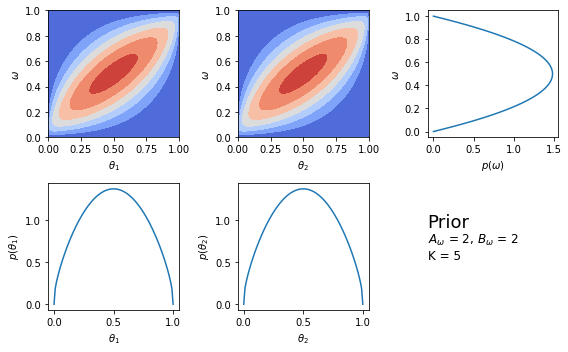

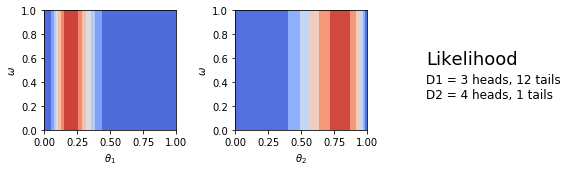

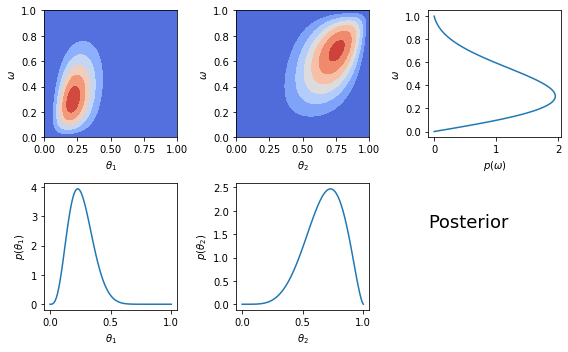

In [15]:
parameters = {
    'a_w': 2,
    'b_w': 2,
    'k': 5,
    'n': [15, 5], 
    'z': [3, 4]
}

plot_figure(parameters)